# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.
 

In [2]:
# Data preprocessing

import numpy as np
import pandas as pd

In [3]:
products = pd.read_csv('amazon_baby_subset.csv')
products.head(2)

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1


### Removing punctuation 

* Remove punctuation
* Compute word counts (only for important_words)

If your tool supports it, fill n/a values in the review column with empty strings. The n/a values indicate empty reviews. For instance, Pandas's the ```fillna()``` method lets you replace all N/A's in the review columns as follows:

In [4]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [5]:
import string

products['review_clean'] = products['review'].str.replace('[{}]'.format(string.punctuation),'')

In [6]:
products.head(5)

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


### Computing the counts

For each word in **important_words**, we compute a count for the number of times the word occurs in the review. We will store this count in a separate column (one for each word). The result of this feature processing is a single column for each word in **important_words** which keeps a count of the number of times the respective word occurs in the review text.

In [8]:
import json
with open('important_words.json', 'r') as f:
    important_words= json.load(f)

In [9]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

## Train-Validation split

Usually, I will use split function to to it. Here, I use pre-ordered Json for this work.

In [10]:
with open('train-idx.json', 'r') as f:
    train_idx = json.load(f)
with open('validation-idx.json', 'r') as f:
    validation_idx = json.load(f)

In [13]:
#train_data = products.values[train_idx]
#validation_data = products.values[validation_idx]

In [16]:
def get_numpy_data(data_Dframe, features, label):
    data_Dframe['intercept'] = 1
    features = ['intercept'] + features
    features_matrix = data_Dframe[features]
    #feature_matrix = features_sframe.to_numpy()
    label_array = data_Dframe[label]
    
    return(features_matrix, label_array)

In [20]:
features, sentiment = get_numpy_data(products, important_words, 'sentiment') 

feature_train = features.values[train_idx]
sentiment_train = sentiment[train_idx]
feature_validation = features.values[validation_idx]
sentiment_validation = sentiment[validation_idx]

In [22]:
print ('Training set   : %d data points' % len(feature_train))
print ('Validation set : %d data points' % len(feature_validation))

Training set   : 42361 data points
Validation set : 10711 data points


## Building on logistic regression with no L2 penalty assignment

Logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

In [23]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    scores = np.dot(feature_matrix, coefficients)
    #scores = np.dot(coefficients, feature_matrix)
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1/(1.+np.exp(-scores))
     
    # return predictions
    return predictions

## Add L2 penalty


Recall logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

** Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [38]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        derivative = derivative - 2 * l2_penalty * coefficient
        
    return derivative

To verify the correctness of the gradient ascent algorithm, we provide a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [33]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.  Fill in the code below to complete this modification.

In [43]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        predictions =  predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative

            derivative = feature_derivative_with_L2(errors, feature_matrix[:, j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            coefficients[j] = coefficients[j] + step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [44]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

In [46]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39508175
iteration   1: log likelihood of observed labels = -29003.73417180
iteration   2: log likelihood of observed labels = -28834.71441858
iteration   3: log likelihood of observed labels = -28671.80345068
iteration   4: log likelihood of observed labels = -28514.58077956
iteration   5: log likelihood of observed labels = -28362.69830317
iteration   6: log likelihood of observed labels = -28215.85663259
iteration   7: log likelihood of observed labels = -28073.79071393
iteration   8: log likelihood of observed labels = -27936.26093762
iteration   9: log likelihood of observed labels = -27803.04751805
iteration  10: log likelihood of observed labels = -27673.94684207
iteration  11: log likelihood of observed labels = -27548.76901327
iteration  12: log likelihood of observed labels = -27427.33612958
iteration  13: log likelihood of observed labels = -27309.48101569
iteration  14: log likelihood of observed labels = -27195.0462

In [47]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.40062984
iteration   1: log likelihood of observed labels = -29003.76654163
iteration   2: log likelihood of observed labels = -28834.79322654
iteration   3: log likelihood of observed labels = -28671.94687528
iteration   4: log likelihood of observed labels = -28514.80571589
iteration   5: log likelihood of observed labels = -28363.02048078
iteration   6: log likelihood of observed labels = -28216.29071186
iteration   7: log likelihood of observed labels = -28074.35036891
iteration   8: log likelihood of observed labels = -27936.95892966
iteration   9: log likelihood of observed labels = -27803.89576265
iteration  10: log likelihood of observed labels = -27674.95647005
iteration  11: log likelihood of observed labels = -27549.95042714
iteration  12: log likelihood of observed labels = -27428.69905549
iteration  13: log likelihood of observed labels = -27311.03455140
iteration  14: log likelihood of observed labels = -27196.7989

In [49]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.48385119
iteration   1: log likelihood of observed labels = -29004.25177457
iteration   2: log likelihood of observed labels = -28835.97382190
iteration   3: log likelihood of observed labels = -28674.09410083
iteration   4: log likelihood of observed labels = -28518.17112932
iteration   5: log likelihood of observed labels = -28367.83774654
iteration   6: log likelihood of observed labels = -28222.77708940
iteration   7: log likelihood of observed labels = -28082.70799392
iteration   8: log likelihood of observed labels = -27947.37595368
iteration   9: log likelihood of observed labels = -27816.54738615
iteration  10: log likelihood of observed labels = -27690.00588850
iteration  11: log likelihood of observed labels = -27567.54970126
iteration  12: log likelihood of observed labels = -27448.98991327
iteration  13: log likelihood of observed labels = -27334.14912742
iteration  14: log likelihood of observed labels = -27222.8604

In [50]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29180.31606471
iteration   1: log likelihood of observed labels = -29009.07176112
iteration   2: log likelihood of observed labels = -28847.62378912
iteration   3: log likelihood of observed labels = -28695.14439397
iteration   4: log likelihood of observed labels = -28550.95060743
iteration   5: log likelihood of observed labels = -28414.45771129
iteration   6: log likelihood of observed labels = -28285.15124375
iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.4242

In [51]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29271.85955115
iteration   1: log likelihood of observed labels = -29271.71006589
iteration   2: log likelihood of observed labels = -29271.65738833
iteration   3: log likelihood of observed labels = -29271.61189923
iteration   4: log likelihood of observed labels = -29271.57079975
iteration   5: log likelihood of observed labels = -29271.53358505
iteration   6: log likelihood of observed labels = -29271.49988440
iteration   7: log likelihood of observed labels = -29271.46936584
iteration   8: log likelihood of observed labels = -29271.44172890
iteration   9: log likelihood of observed labels = -29271.41670149
iteration  10: log likelihood of observed labels = -29271.39403722
iteration  11: log likelihood of observed labels = -29271.37351294
iteration  12: log likelihood of observed labels = -29271.35492661
iteration  13: log likelihood of observed labels = -29271.33809523
iteration  14: log likelihood of observed labels = -29271.3228

## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

In [96]:
table = pd.DataFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

Now, let's run the function `add_coefficients_to_table` for each of the L2 penalty strengths.

In [97]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),-0.063742,-0.063143,-0.062256,-0.050438,0.000054,0.011362
1,baby,0.074073,0.073994,0.073877,0.072360,0.059752,0.001784
2,one,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827
3,great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950
4,love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042
5,use,-0.000104,0.000163,0.000556,0.005481,0.017326,0.000418
6,would,-0.287021,-0.286027,-0.284564,-0.265993,-0.188662,-0.008127
7,like,-0.003384,-0.003442,-0.003527,-0.004635,-0.007043,-0.000827
8,easy,0.984559,0.977600,0.967362,0.838245,0.401904,0.008808
9,little,0.524419,0.521385,0.516917,0.460235,0.251221,0.005941


Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

**Quiz Question**. Which of the following is **not** listed in either **positive_words** or **negative_words**?

In [98]:
result_view = table[['word', 'coefficients [L2=0]' ]]

In [99]:
result_view = result_view.sort_values(by = 'coefficients [L2=0]',ascending=False)

In [104]:
result_view[0:5]

,word,coefficients [L2=0]
4,love,1.058554
23,loves,1.052484
8,easy,0.984559
34,perfect,0.835693
3,great,0.801625


In [105]:
result_view[-5:]

,word,coefficients [L2=0]
169,returned,-0.572707
113,waste,-0.617809
114,return,-0.742085
97,money,-0.768793
106,disappointed,-0.955437


Let us observe the effect of increasing L2 penalty on the 10 words just selected. 

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)

        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

In [102]:
positive_words = result_view[0:5]['word'].values
negative_words = result_view[-5:]['word'].values

In [103]:
positive_words

array(['love', 'loves', 'easy', 'perfect', 'great'], dtype=object)

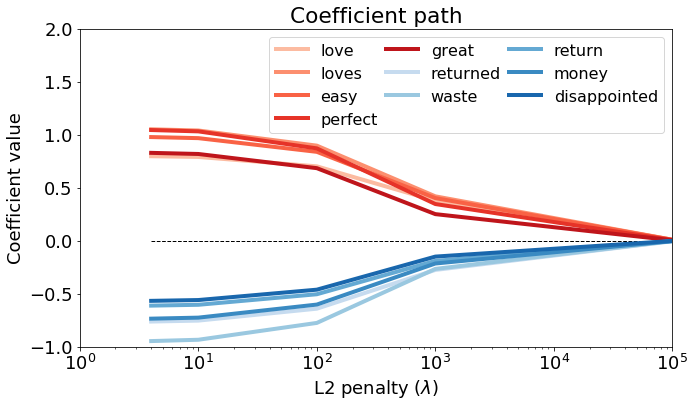

In [108]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as the L2 penalty is increased.

**Quiz Question**: (True/False) The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)

## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.


In [109]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

In [113]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_validation, sentiment_validation, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_validation, sentiment_validation, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_validation, sentiment_validation, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_validation, sentiment_validation, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_validation, sentiment_validation, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_validation, sentiment_validation, coefficients_1e5_penalty)

In [114]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print ("L2 penalty = %g" % key)
    print ("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print ("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.785156157787, validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.785108944548, validation_accuracy = 0.781533003454
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.784990911452, validation_accuracy = 0.781719727383
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.783975826822, validation_accuracy = 0.781066193633
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.775855149784, validation_accuracy = 0.771356549342
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.680366374731, validation_accuracy = 0.667818130893
---------------------------------------------------------------------------

Text(0,0.5,'Accuracy')

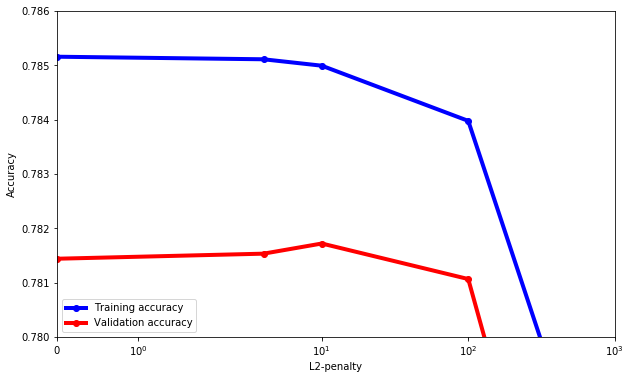

In [117]:
# Optional. Plot accuracy on training and validation sets over choice of L2 penalty.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
plt.axis([0, 1e3, 0.78, 0.786])
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout
plt.xlabel('L2-penalty')
plt.ylabel('Accuracy')

* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **training** data?
* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **validation** data?
* **Quiz Question**: Does the **highest** accuracy on the **training** data imply that the model is the best one?